# Decompose HSC observed galaxy image as disk + bulge

This notebook requires standard python libraries and the publicly available packages on github:
See https://github.com/dartoon/galight/blob/master/requirements.txt

This notebook has been tested with galight ==  0.1.0

For more information, please contact me: dingxuheng@126.com

This notebook is very similar to the 'galight_HSC_QSO.ipynb', only that there is no AGN and galaxy are fitted as double components.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

#Data is available at: https://drive.google.com/file/d/1Axwo-aD5yFrkuHIlYBsQ8ma1nHRpcAHg/view?usp=sharing
fitsFile = pyfits.open('../example_files/HSC/galaxy/18184_HSC-I.fits')

#Load the fov image data:
fov_image = fitsFile[1].data # check the back grounp

#Derive the header informaion, might be used to obtain the pixel scale and the exposure time.
header = fitsFile[1].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']

#Derive the fov noise level map:
err_data= fitsFile[3].data ** 0.5

#Calculate the zeropoint for HSC filters:
file_header0 = fitsFile[0].header
FLUXMAG0 = file_header0['FLUXMAG0']
zp =  2.5 * np.log10(FLUXMAG0)   # This is something Xuheng can't make sure.

#Load the PSF data:
PSF = pyfits.getdata('../example_files/HSC/galaxy/18184_HSC-I_psf.fits')

Estimating the background light ... ... ...
Plot target cut out zoom in:


/Users/Dartoon/Astro/my_packages/galight/galight/data_process.py:191: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im1 = ax1.imshow(target_stamp, origin='lower', norm=LogNorm(), vmax = target_stamp.max(), vmin = 1.e-4)
/Users/Dartoon/Astro/my_packages/galight/galight/data_process.py:201: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im3 = ax3.imshow(target_stamp * target_mask, origin='lower', norm=LogNorm(), vmax = target_stamp.max(), vmin = 1.e-4)


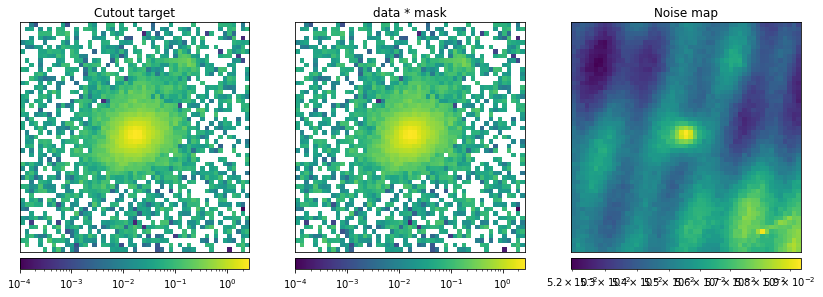

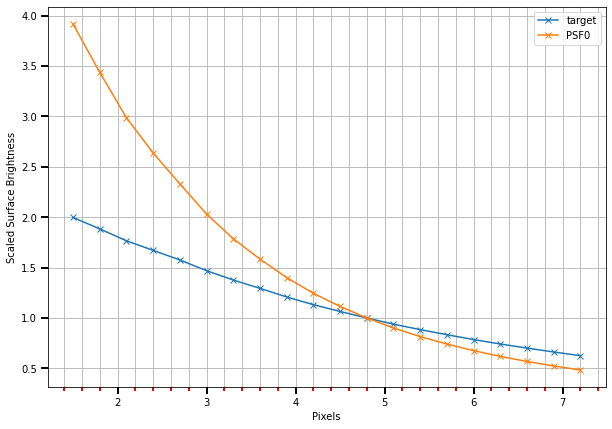

The PSF is not a box size, will cut it to a box size automatically.
The data_process is ready to go to pass to FittingSpecify!


In [2]:
from galight.data_process import DataProcess

#RA, DEC information of the galaxy:
galaxy_RA, galaxy_DEC = 150.1217832, 2.394535983
data_process = DataProcess(fov_image = fov_image, fov_noise_map = err_data, target_pos = [galaxy_RA, galaxy_DEC],
                           pos_type = 'wcs', header = header,
                          rm_bkglight = True, if_plot=False, zp = zp)

#Generate the fitting materials
data_process.generate_target_materials(radius=25, create_mask = False, nsigma=2.8,
                                      exp_sz= 1.5, npixels = 15, if_plot=True)

#Manually input the PSF:
data_process.PSF_list = [PSF]

# Compare the 1D profile of all the components.
data_process.profiles_compare(norm_pix = 5, if_annuli=False, y_log = False,
                  prf_name_list = (['target'] + ['PSF{0}'.format(i) for i in range(len(data_process.PSF_list))]) )


#Check if all the materials is given, if so to pass to the next step.
data_process.checkout() #Check if all the materials is known.

The settings for the fitting is done. Ready to pass to FittingProcess. 
  However, please make updates manullay if needed.


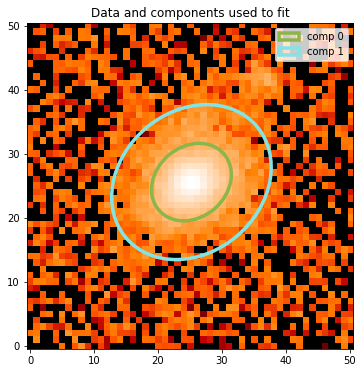

In [3]:
#Modify the fitting of the component (i.e., galaxy) id = 0 into to components (i.e., bulge + disk)
import copy
apertures = copy.deepcopy(data_process.apertures)
comp_id = 0 
add_aperture0 = copy.deepcopy(apertures[comp_id])
#This setting assigns comp0 as 'bulge' and comp1 as 'disk'
add_aperture0.a, add_aperture0.b = add_aperture0.a/2, add_aperture0.b/2
apertures = apertures[:comp_id] + [add_aperture0] + apertures[comp_id:]
data_process.apertures = apertures #Pass apertures to the data_process

#Adding a prior so that 1)the size of the bulge is within a range to the disk size. 2) disk have more ellipticity.
import lenstronomy.Util.param_util as param_util
def condition_bulgedisk(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps, kwargs_special, kwargs_extinction):
    logL = 0
    #note that the Comp[0] is the bulge and the Comp[1] is the disk.
    phi0, q0 = param_util.ellipticity2phi_q(kwargs_lens_light[0]['e1'], kwargs_lens_light[0]['e2'])
    phi1, q1 = param_util.ellipticity2phi_q(kwargs_lens_light[1]['e1'], kwargs_lens_light[1]['e2'])
    cond_0 = (kwargs_lens_light[0]['R_sersic'] > kwargs_lens_light[1]['R_sersic'] * 0.9)
    cond_1 = (kwargs_lens_light[0]['R_sersic'] < kwargs_lens_light[1]['R_sersic']*0.15)
    cond_2 = (q0 < q1)
    if cond_0 or cond_1 or cond_2:
        logL -= 10**15
    return logL

#Start to produce the class and params for fitting.
#For more details, see notebook galight_HSC_QSO.ipynb
from galight.fitting_specify import FittingSpecify
fit_sepc = FittingSpecify(data_process)
#The 'fix_n_list' will fix Sersic_n as 4 for the comp0, and as 1 for the comp1.
fit_sepc.prepare_fitting_seq(point_source_num = 0, fix_n_list= [[0,4], [1,1]],condition=condition_bulgedisk)

#The settings of the parameters is the dict defined by fit_sepc.kwargs_params. One can modify the values herein to change the default setting manually. 

#Plot the initial settings for fittings. 
fit_sepc.build_fitting_seq()
fit_sepc.plot_fitting_sets()

Computing the PSO ...
10
20
30
40


  0%|          | 0/130 [00:00<?, ?it/s]

50
Max iteration reached! Stopping.
-1.1589454522183464 reduced X^2 of best position
-1500.2548878966495 logL
2589.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.6536338847184219, 'n_sersic': 4, 'e1': 0.1663098238797689, 'e2': -0.11552789380206518, 'center_x': -0.015055814815670076, 'center_y': 0.07724962764858817}, {'amp': 1, 'R_sersic': 1.0823250125654396, 'n_sersic': 1, 'e1': -0.0517373814147792, 'e2': -0.1985183310753135, 'center_x': -0.07685478020413772, 'center_y': 0.09110067065452376}] lens light result
[] point source result
{} special param result
4.816424131393433 time used for  PSO


100%|██████████| 130/130 [00:25<00:00,  5.00it/s]


Computing the MCMC...
Number of walkers =  100
Burn-in iterations:  100
Sampling iterations (in current run): 130
26.17368197441101 time taken for MCMC sampling
31.005 total time taken for the overall fitting (s)
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 
Start transfering the Params to fluxs...
3000 MCMC samplers in total, finished translate: 1000
3000 MCMC samplers in total, finished translate: 2000


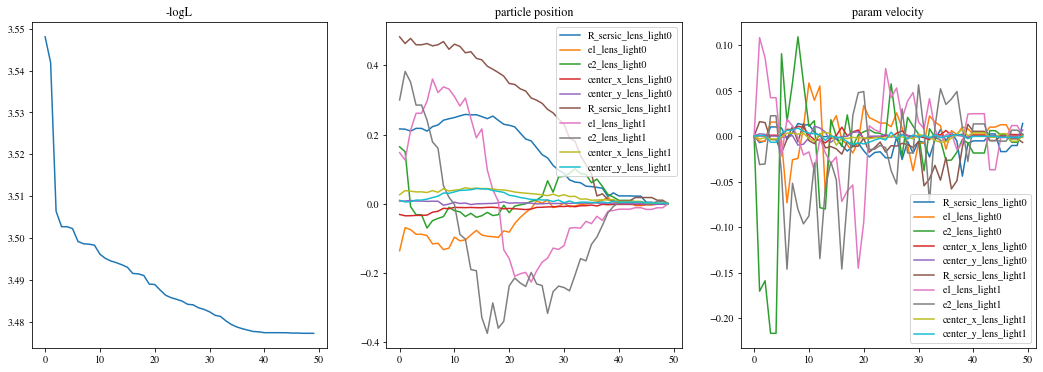

<Figure size 432x288 with 0 Axes>

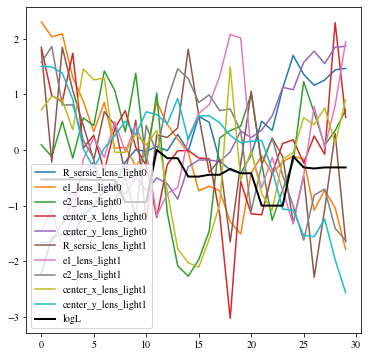

-1.1533104751076988 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.1533104751076986


/Users/Dartoon/.local/lib/python3.6/site-packages/lenstronomy/Plots/model_band_plot.py:57: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_bad(color='k', alpha=1.)
/Users/Dartoon/.local/lib/python3.6/site-packages/lenstronomy/Plots/model_band_plot.py:58: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_under('k')


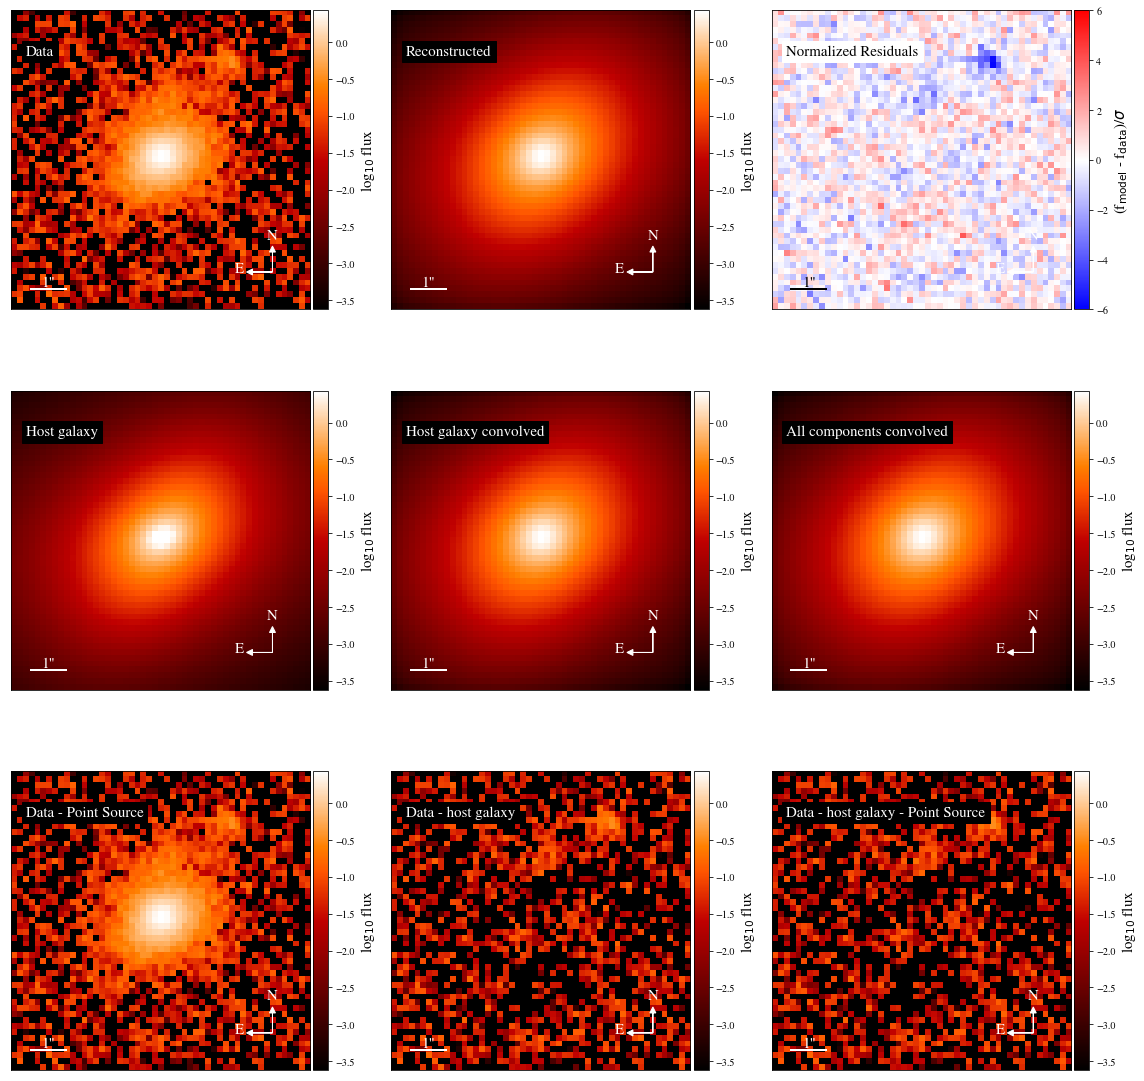

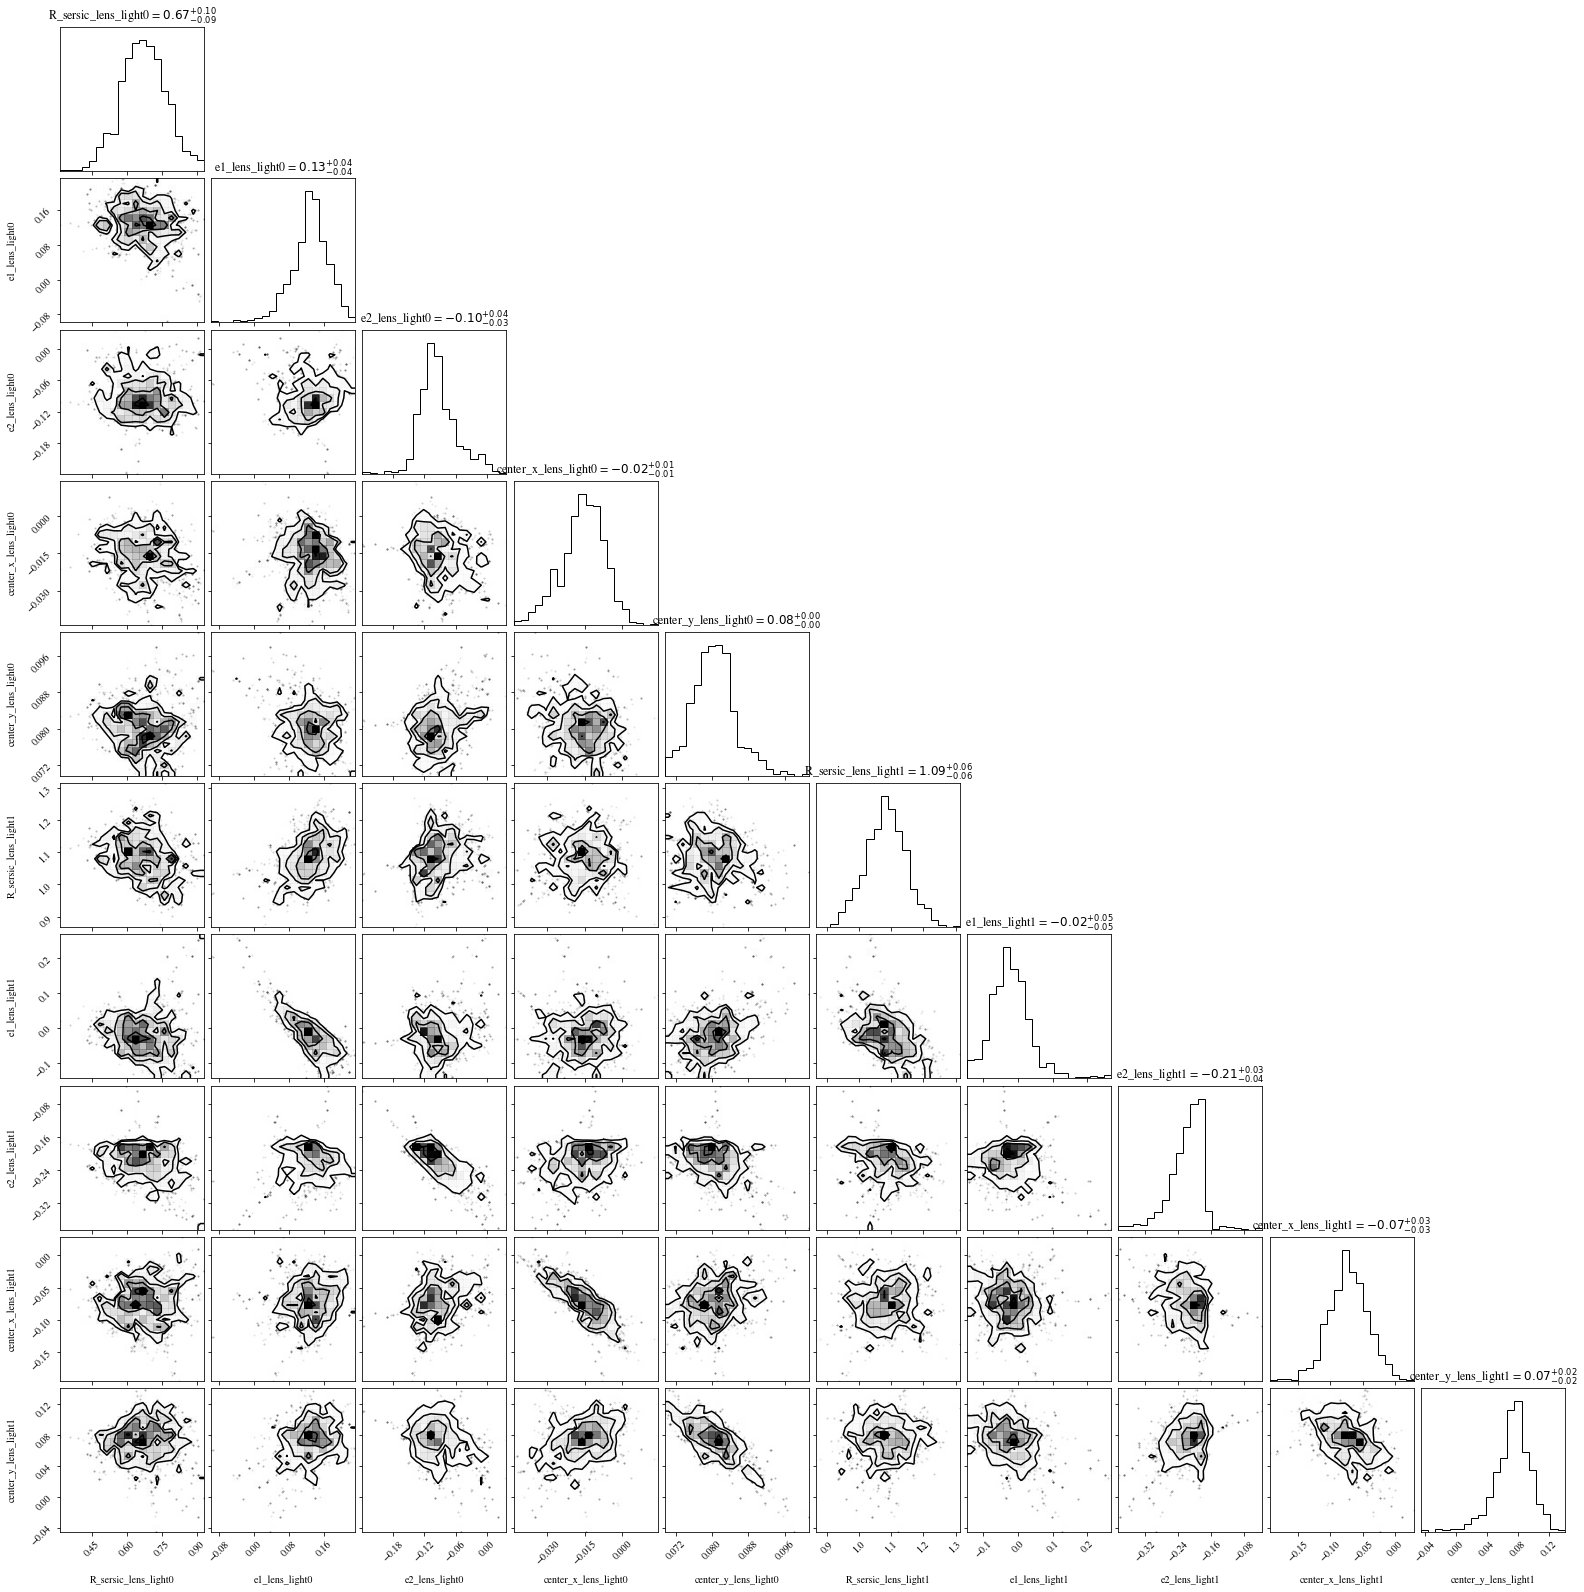

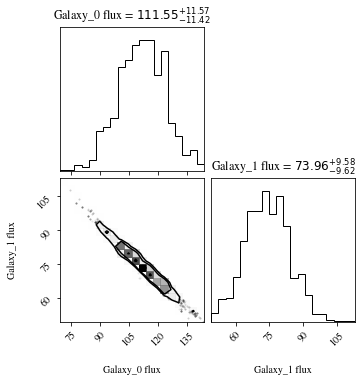

/Users/Dartoon/Astro/my_packages/galight/galight/tools/plot_tools.py:105: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  vmax = flux_list_2d[0].max(), vmin = 1.e-4)


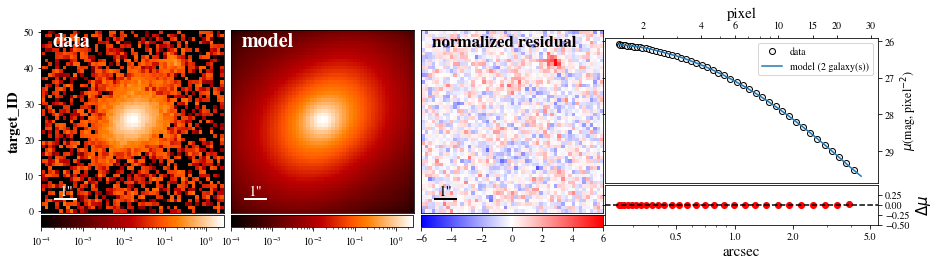

In [4]:
#Setting the fitting method and run.
from galight.fitting_process import FittingProcess

#Pass fit_sepc to FittingProcess,
# savename: The name of the saved files.    
fit_run = FittingProcess(fit_sepc, savename = 'HSC_galaxy_result')

#Setting the fitting approach and Run: 
#     algorithm_list: The fitting approaches that would be used: e.g. ['PSO', 'PSO', 'MCMC']
#     setting_list: The detailed setting for the fitting: e.g. [[0.8, 50, 50], [0.8, 50, 50], [50, 100, 10, 0.1]]
#     -for PSO:
#         input template: {'sigma_scale': 0.8, 'n_particles': 50, 'n_iterations': 50}
#     -for MCMC:
#         input template: {'n_burn': 50, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .1}
#     if setting_list = [None, None, None], default values would be given 
fit_run.run(algorithm_list = ['PSO', 'MCMC'], setting_list = [None, None])

# Plot all the fitting results, including:
#         run_diag() : The convergence of the chains.
#         model_plot(): The model plot (by lenstronomy)
#         plot_params_corner(): The mcmc corner for all the chains (MCMC should be peformed) 
#         plot_flux_corner(): The flux corner for all the component (MCMC should be peformed)
#         plot_final_qso_fit() or plot_final_galaxy_fit(): Plot the overall plot (data, model, data-ps, resudal, 1D profile)
fit_run.plot_all()


#Save the fitting class as pickle format:
#     Note, if you use python3 (or 2), load with python3 (or 2)
fit_run.dump_result()

/Users/Dartoon/Astro/my_packages/galight/galight/tools/plot_tools.py:105: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  vmax = flux_list_2d[0].max(), vmin = 1.e-4)


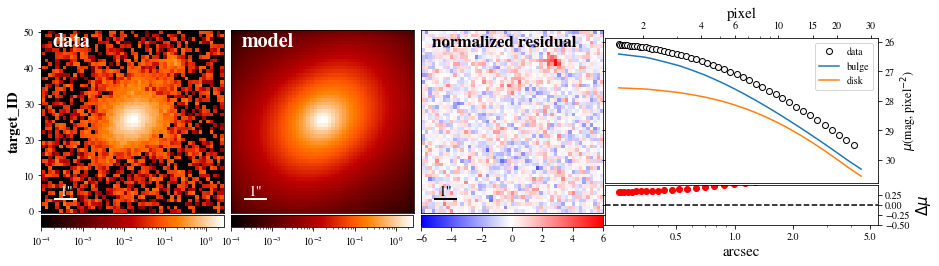

In [5]:
from galight.tools.plot_tools import total_compare
data = fit_run.fitting_specify_class.kwargs_data['image_data']
noise = fit_run.fitting_specify_class.kwargs_data['noise_map']
galaxy_list = fit_run.image_host_list
galaxy_total_image = np.zeros_like(galaxy_list[0])
for i in range(len(galaxy_list)):
    galaxy_total_image = galaxy_total_image+galaxy_list[i]
model = galaxy_total_image
norm_residual = (data - model)/noise
flux_list_2d = [data, model, norm_residual]
label_list_2d = ['data', 'model', 'normalized residual']
flux_list_1d = [data, galaxy_list[0], galaxy_list[1]]
label_list_1d = ['data', 'bulge', 'disk']
total_compare(flux_list_2d, label_list_2d, flux_list_1d, label_list_1d, deltaPix = fit_run.fitting_specify_class.deltaPix,
                      zp=fit_run.zp, if_annuli=False, arrows= False, show_plot = False,
                      target_ID = 'target_ID')


In [6]:
#Load the saved fitting class, the fitting_run_result would be the loaded as fit_run() in previous fittings.
import pickle
picklename = 'HSC_galaxy_result.pkl'
fitting_run_result = pickle.load(open(picklename,'rb'))
#fitting_run_result.plot_final_qso_fit()
fitting_run_result.final_result_galaxy

[{'amp': 19.818890144637443,
  'R_sersic': 0.5936069720300587,
  'n_sersic': 4,
  'e1': 0.14990964916852634,
  'e2': -0.09333375464846502,
  'center_x': -0.01282621749728569,
  'center_y': 0.08080519371070063,
  'phi_G': -0.2784358223947188,
  'q': 0.69982720338177,
  'flux_sersic_model': 110.76942618261556,
  'flux_within_frame': 102.55647118679576,
  'magnitude': 21.972592327462625},
 {'amp': 8.637406106001523,
  'R_sersic': 1.104736760162113,
  'n_sersic': 1,
  'e1': -0.04006041390442779,
  'e2': -0.20658008828267332,
  'center_x': -0.07323110637432158,
  'center_y': 0.06961258252329923,
  'phi_G': -0.8811704185527488,
  'q': 0.6523073746906074,
  'flux_sersic_model': 82.26070296201203,
  'flux_within_frame': 81.96477551419218,
  'magnitude': 22.215931865579417}]